In [1]:
!pip install torchattacks


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchattacks

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:05<00:00, 33403010.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


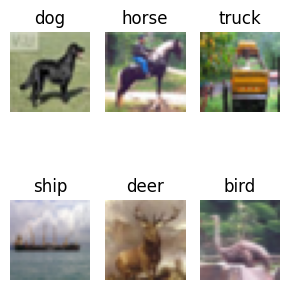

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

batch_size = 6
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(3, 4))  # 6 columns and 4 rows
for i in range(batch_size):
    plt.subplot(2, 3, i + 1)
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"{classes[labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
# Automatically use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Ensure model is on the correct device
model = SimpleCNN().to(device)


Using device: cuda


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to the correct device
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move to the correct device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch 1/5, Loss: 1.3703, Train Accuracy: 0.5112, Val Accuracy: 0.6108
Epoch 2/5, Loss: 0.9983, Train Accuracy: 0.6482, Val Accuracy: 0.6484
Epoch 3/5, Loss: 0.8349, Train Accuracy: 0.7066, Val Accuracy: 0.6650
Epoch 4/5, Loss: 0.7248, Train Accuracy: 0.7472, Val Accuracy: 0.7113
Epoch 5/5, Loss: 0.6251, Train Accuracy: 0.7793, Val Accuracy: 0.7149


In [8]:
torch.save(model.state_dict(), 'cifar10_model.pth')


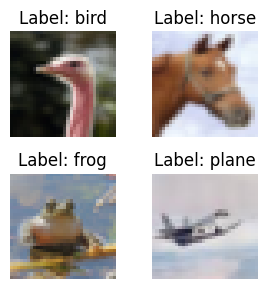

In [9]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)  # Move to the correct device

plt.figure(figsize=(3, 3))
for i in range(min(4, len(labels))):
    plt.subplot(2, 2, i + 1)
    imshow(torchvision.utils.make_grid(images[i].cpu()))  # Ensure images are moved back to CPU for visualization
    plt.title(f"Label: {classes[labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [10]:
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('cifar10_model.pth'))


<All keys matched successfully>

In [11]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)  # Ensure images are on the correct device

outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))


Predicted:  deer  truck deer  ship 


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Ensure images are on the correct device
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 71 %


In [13]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Ensure images are on the correct device
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname] if total_pred[classname] > 0 else 0
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 77.9 %
Accuracy for class: car   is 78.5 %
Accuracy for class: bird  is 53.5 %
Accuracy for class: cat   is 60.2 %
Accuracy for class: deer  is 74.9 %
Accuracy for class: dog   is 60.9 %
Accuracy for class: frog  is 71.7 %
Accuracy for class: horse is 75.3 %
Accuracy for class: ship  is 81.7 %
Accuracy for class: truck is 80.3 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Ensure images are on the correct device
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 77.9 %
Accuracy for class: car   is 78.5 %
Accuracy for class: bird  is 53.5 %
Accuracy for class: cat   is 60.2 %
Accuracy for class: deer  is 74.9 %
Accuracy for class: dog   is 60.9 %
Accuracy for class: frog  is 71.7 %
Accuracy for class: horse is 75.3 %
Accuracy for class: ship  is 81.7 %
Accuracy for class: truck is 80.3 %


Auto Attack

Success Rate: 0.6562


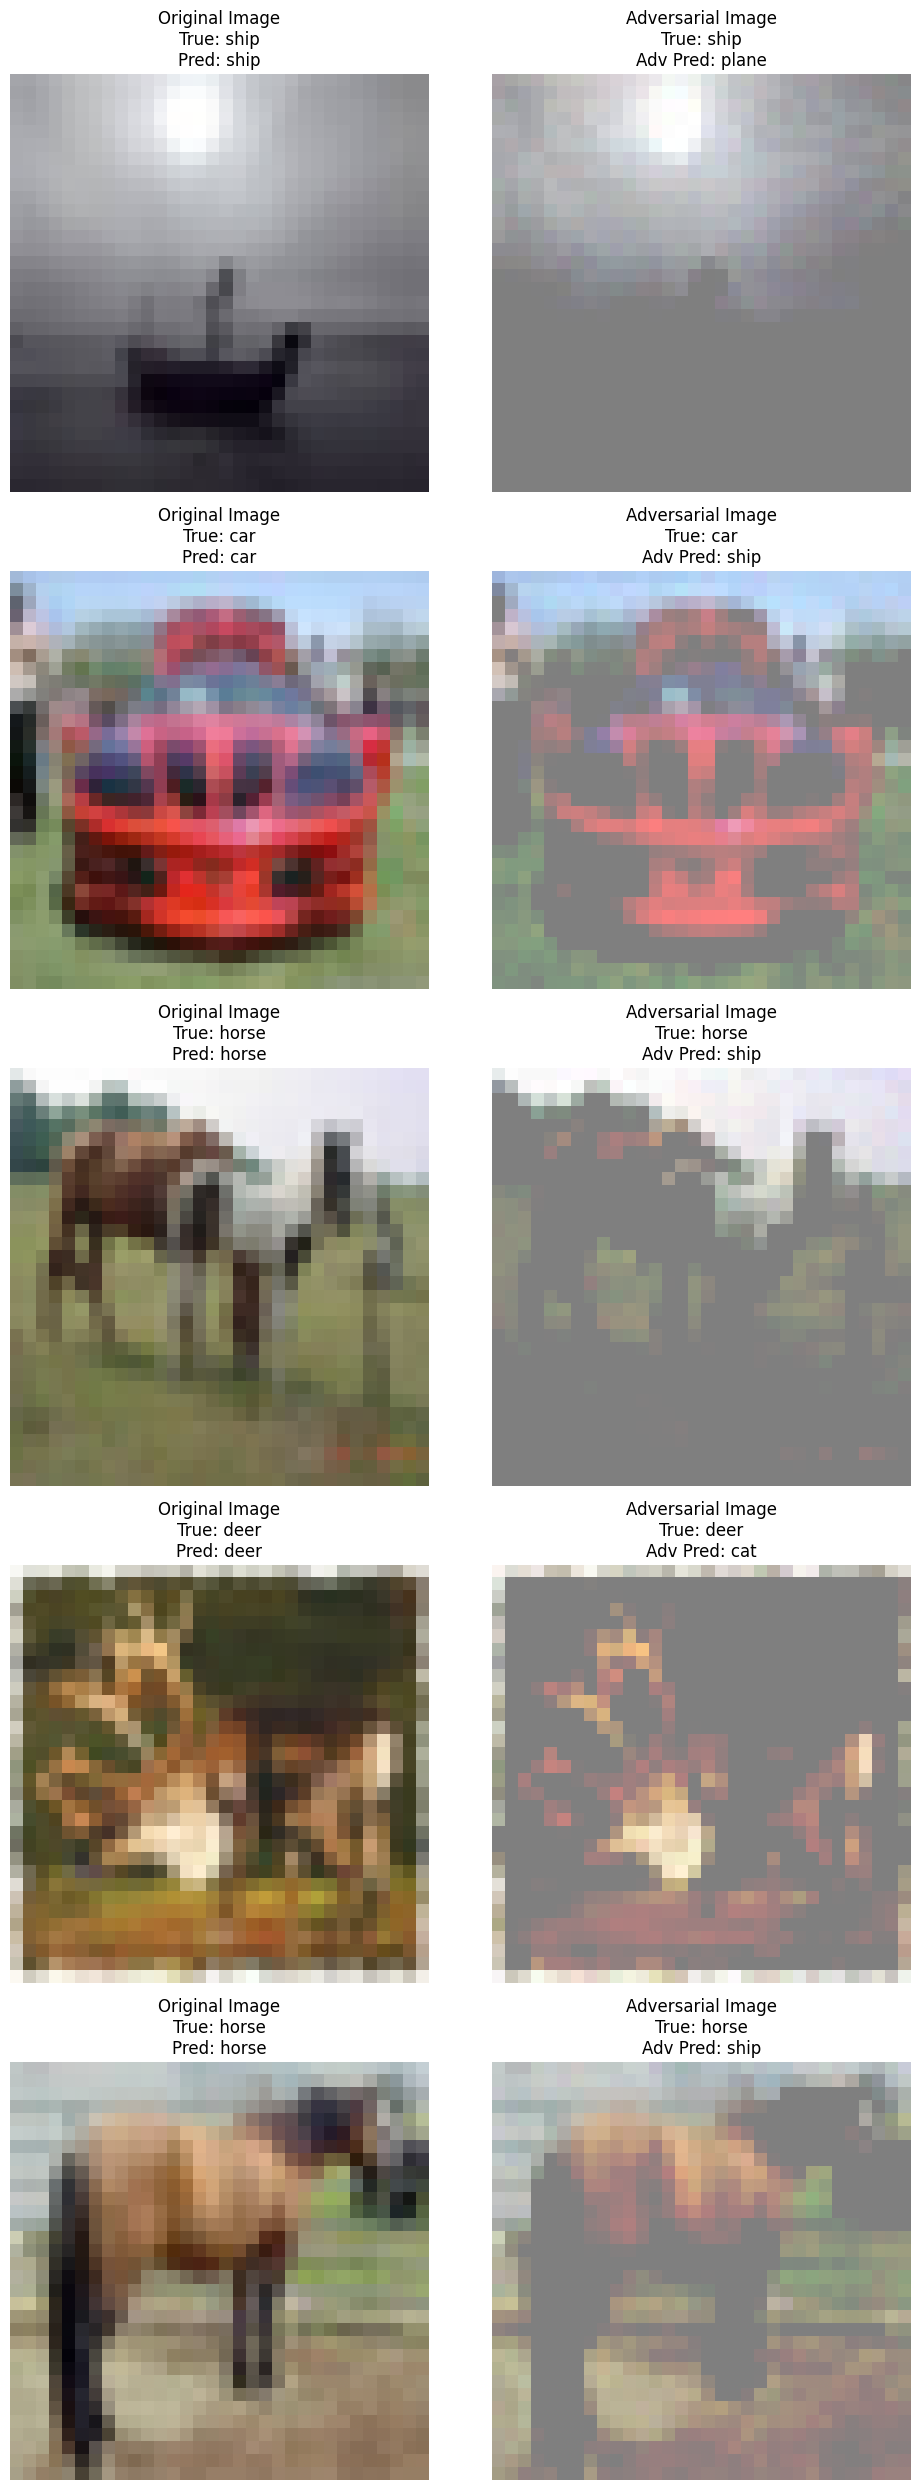

In [18]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the AutoAttack
attack_auto = torchattacks.AutoAttack(model, norm='Linf', eps=8/255, version='standard', n_classes=10, seed=None, verbose=False)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        if batch_idx >= num_batches_to_process:
            break

        images, labels = images.to(device), labels.to(device)
        adv_images = attack_auto(images, labels)

        # Predictions on original and adversarial images
        original_predictions = model(images)
        adversarial_predictions = model(adv_images)

        original_pred_labels = torch.argmax(original_predictions, dim=1)
        adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

        # Compare predictions to determine if attack was successful
        for i in range(len(labels)):
            if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
                successful_attacks += 1
                examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

        total_samples += labels.size(0)

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


Square Attack


Success Rate: 0.6156


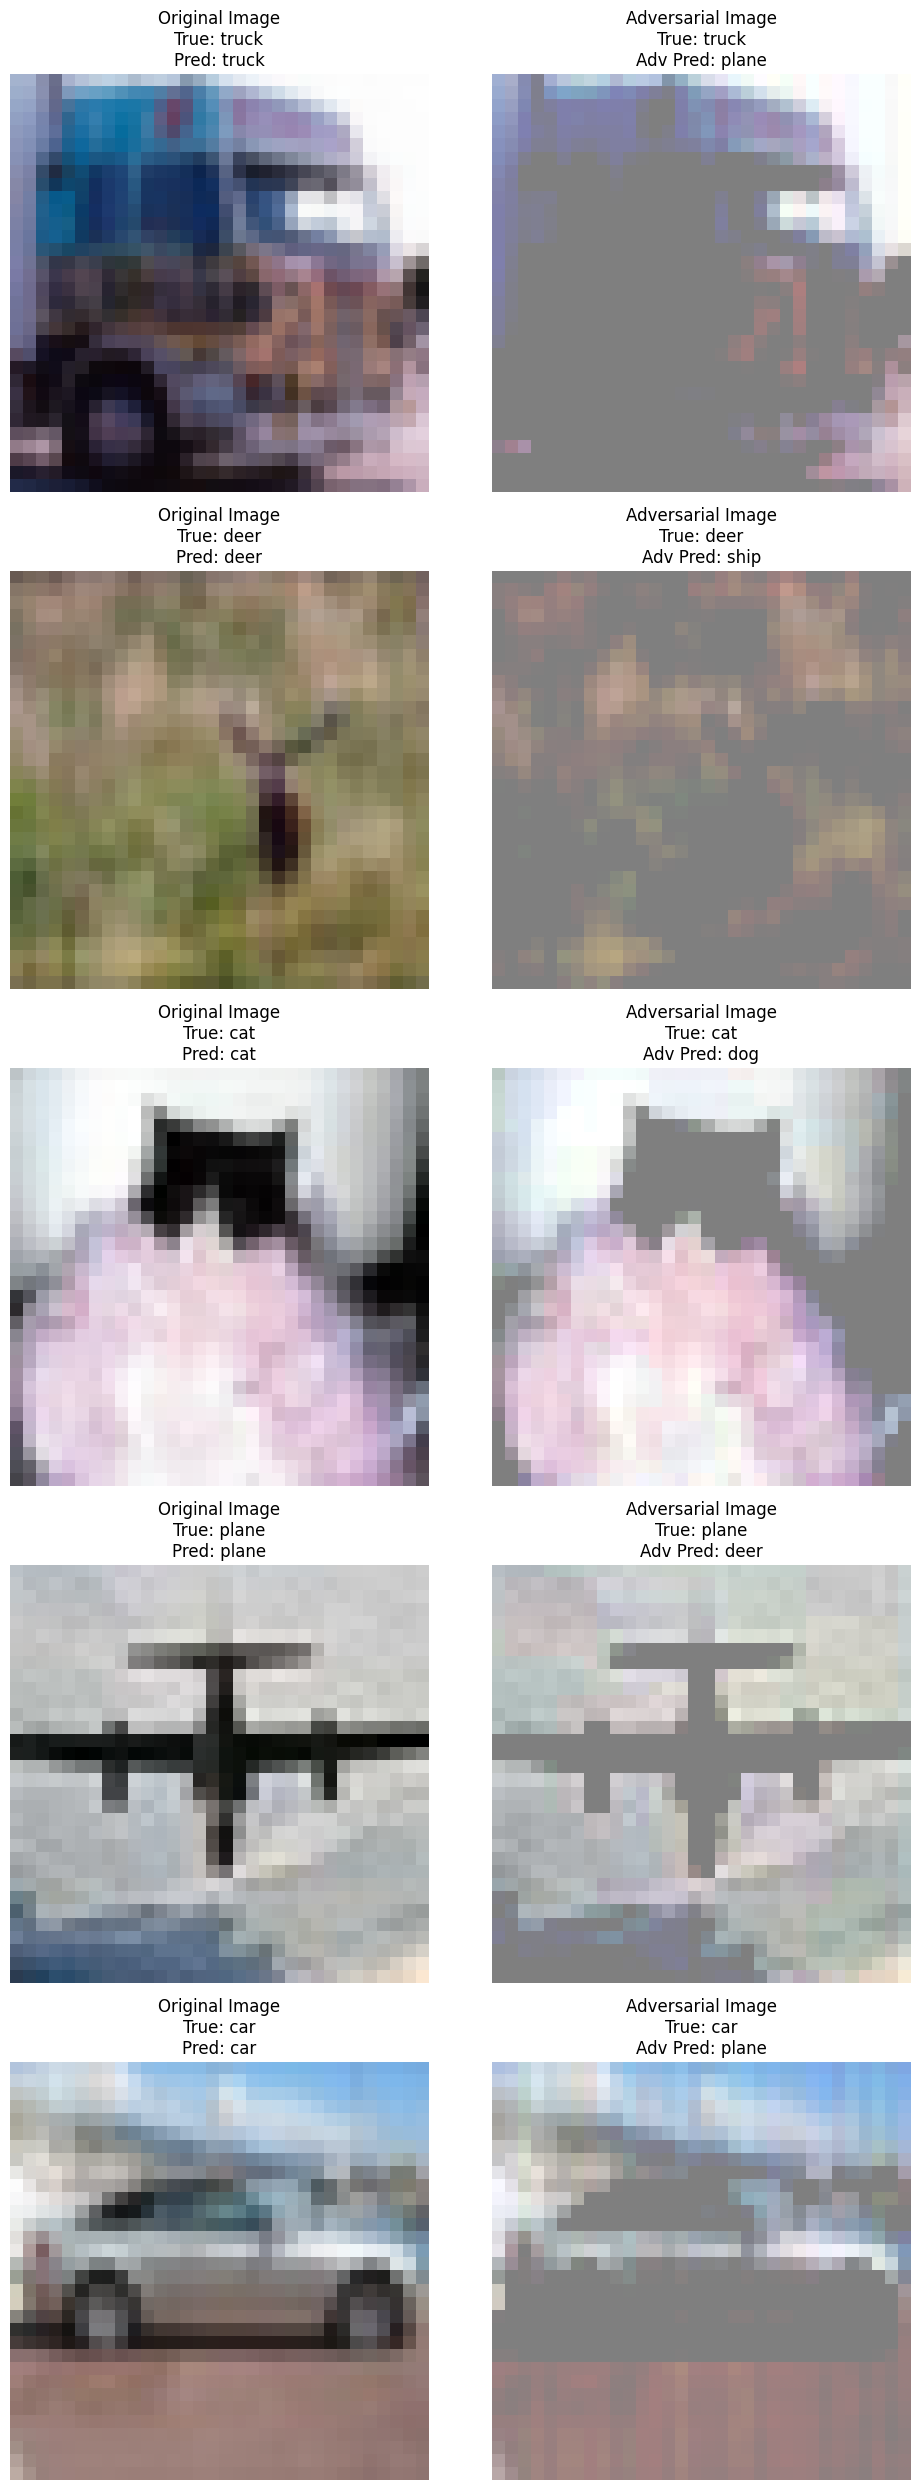

In [19]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Square Attack
attack_square = torchattacks.Square(model, norm='Linf', eps=8/255, n_queries=5000, n_restarts=1, p_init=0.8, loss='margin', resc_schedule=True, seed=0, verbose=False)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        if batch_idx >= num_batches_to_process:
            break

        images, labels = images.to(device), labels.to(device)
        adv_images = attack_square(images, labels)

        # Predictions on original and adversarial images
        original_predictions = model(images)
        adversarial_predictions = model(adv_images)

        original_pred_labels = torch.argmax(original_predictions, dim=1)
        adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

        # Compare predictions to determine if attack was successful
        for i in range(len(labels)):
            if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
                successful_attacks += 1
                examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

        total_samples += labels.size(0)

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


SPSA Attack

Success Rate: 0.4297


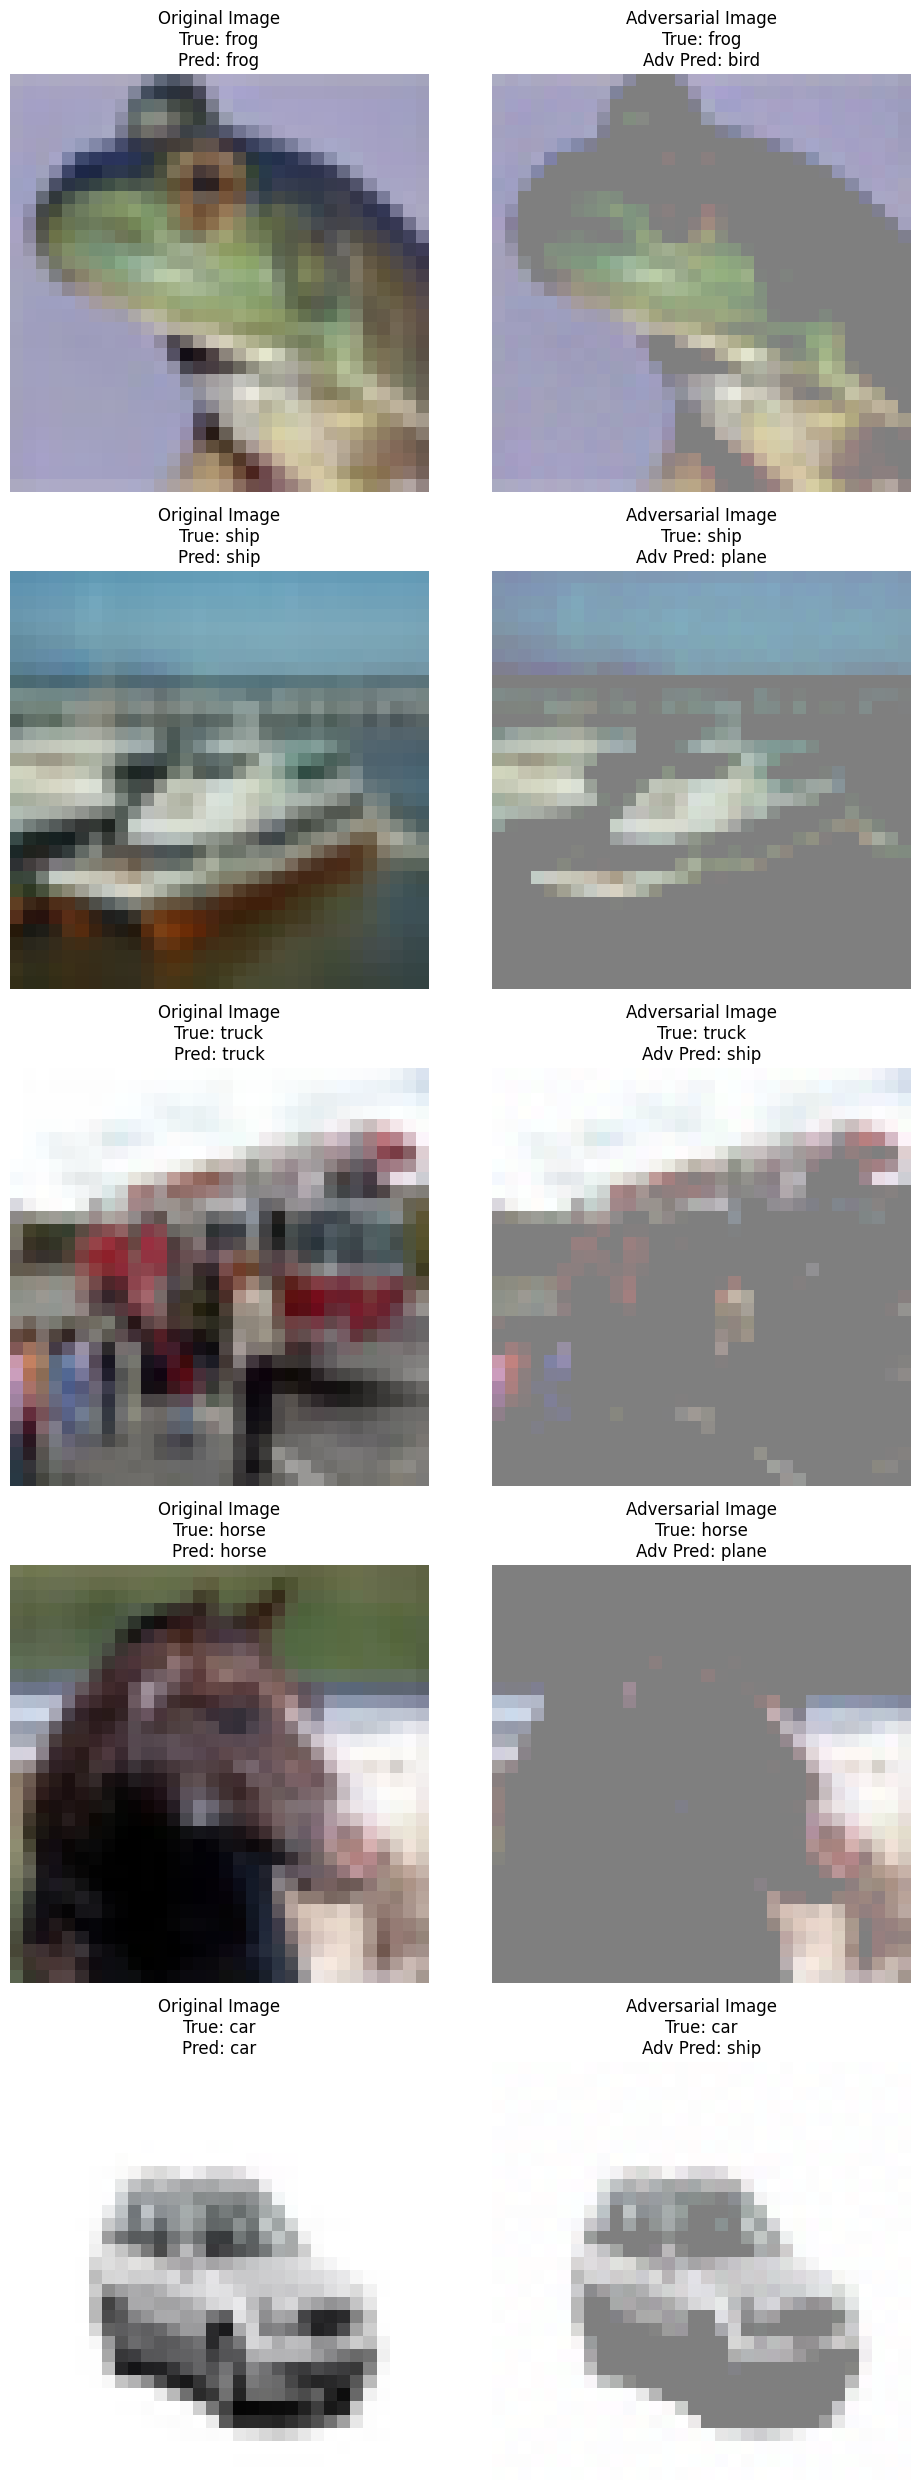

In [20]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the SPSA Attack
attack_spsa = torchattacks.SPSA(model, eps=8/255, delta=0.01, lr=0.01, nb_iter=1, nb_sample=128, max_batch_size=64)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        if batch_idx >= num_batches_to_process:
            break

        images, labels = images.to(device), labels.to(device)
        adv_images = attack_spsa(images, labels)

        # Predictions on original and adversarial images
        original_predictions = model(images)
        adversarial_predictions = model(adv_images)

        original_pred_labels = torch.argmax(original_predictions, dim=1)
        adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

        # Compare predictions to determine if attack was successful
        for i in range(len(labels)):
            if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
                successful_attacks += 1
                examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

        total_samples += labels.size(0)

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


JSMA Attack

Success Rate: 0.7063


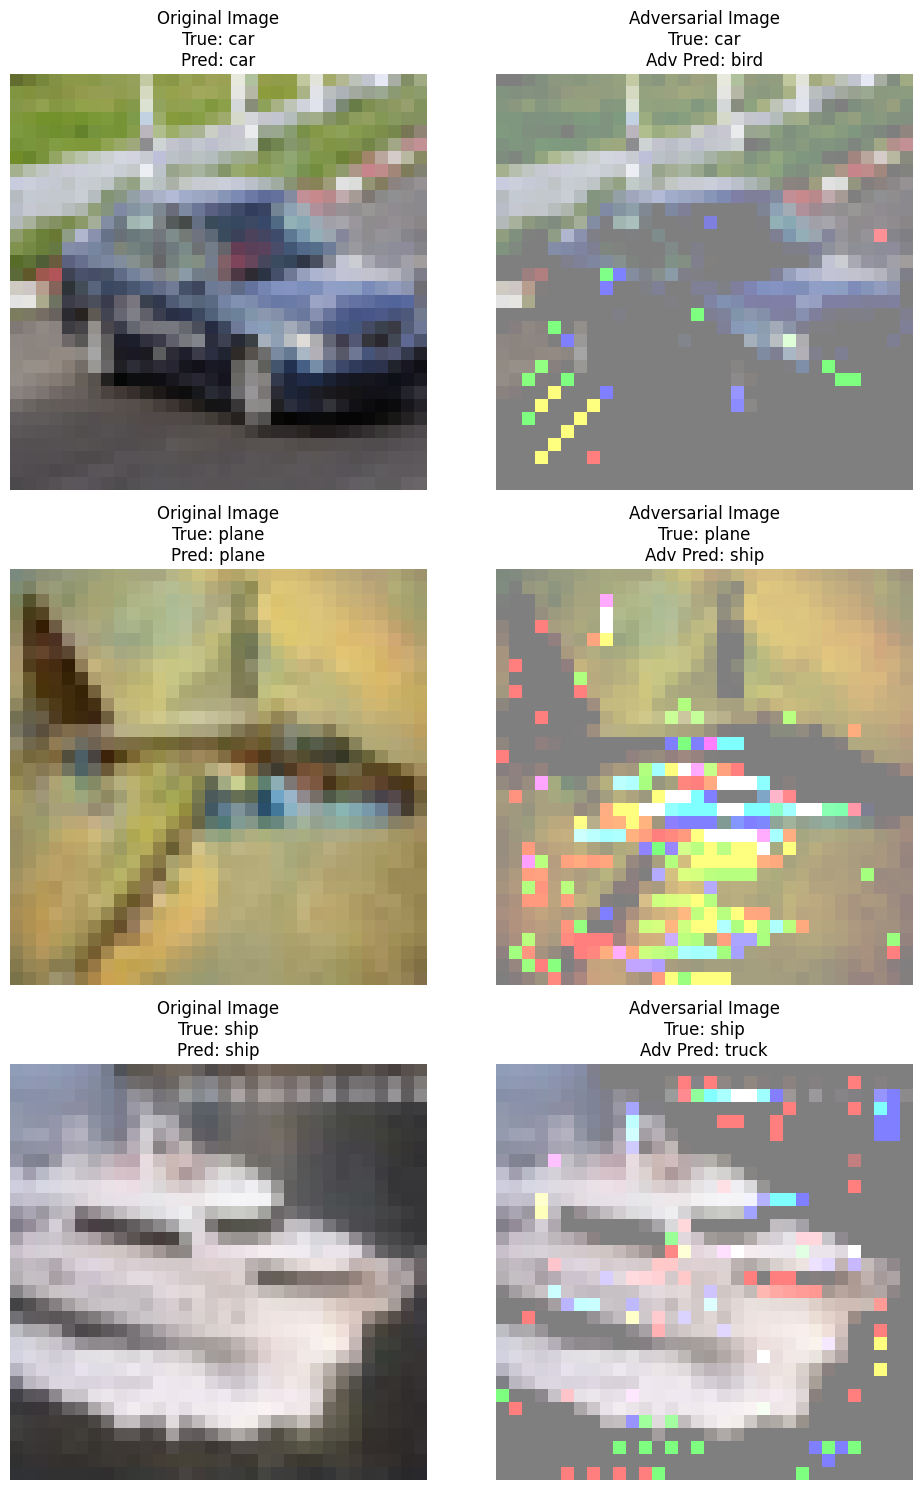

In [25]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the JSMA Attack with simpler parameters
attack_jsma = torchattacks.JSMA(model, theta=1.0, gamma=0.1)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 5  # Reduce the number of batches to process for faster execution

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_jsma(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(3, len(examples))  # Reduce the number of examples to show for faster visualization
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


EADL1 Attack

Success Rate: 0.7141


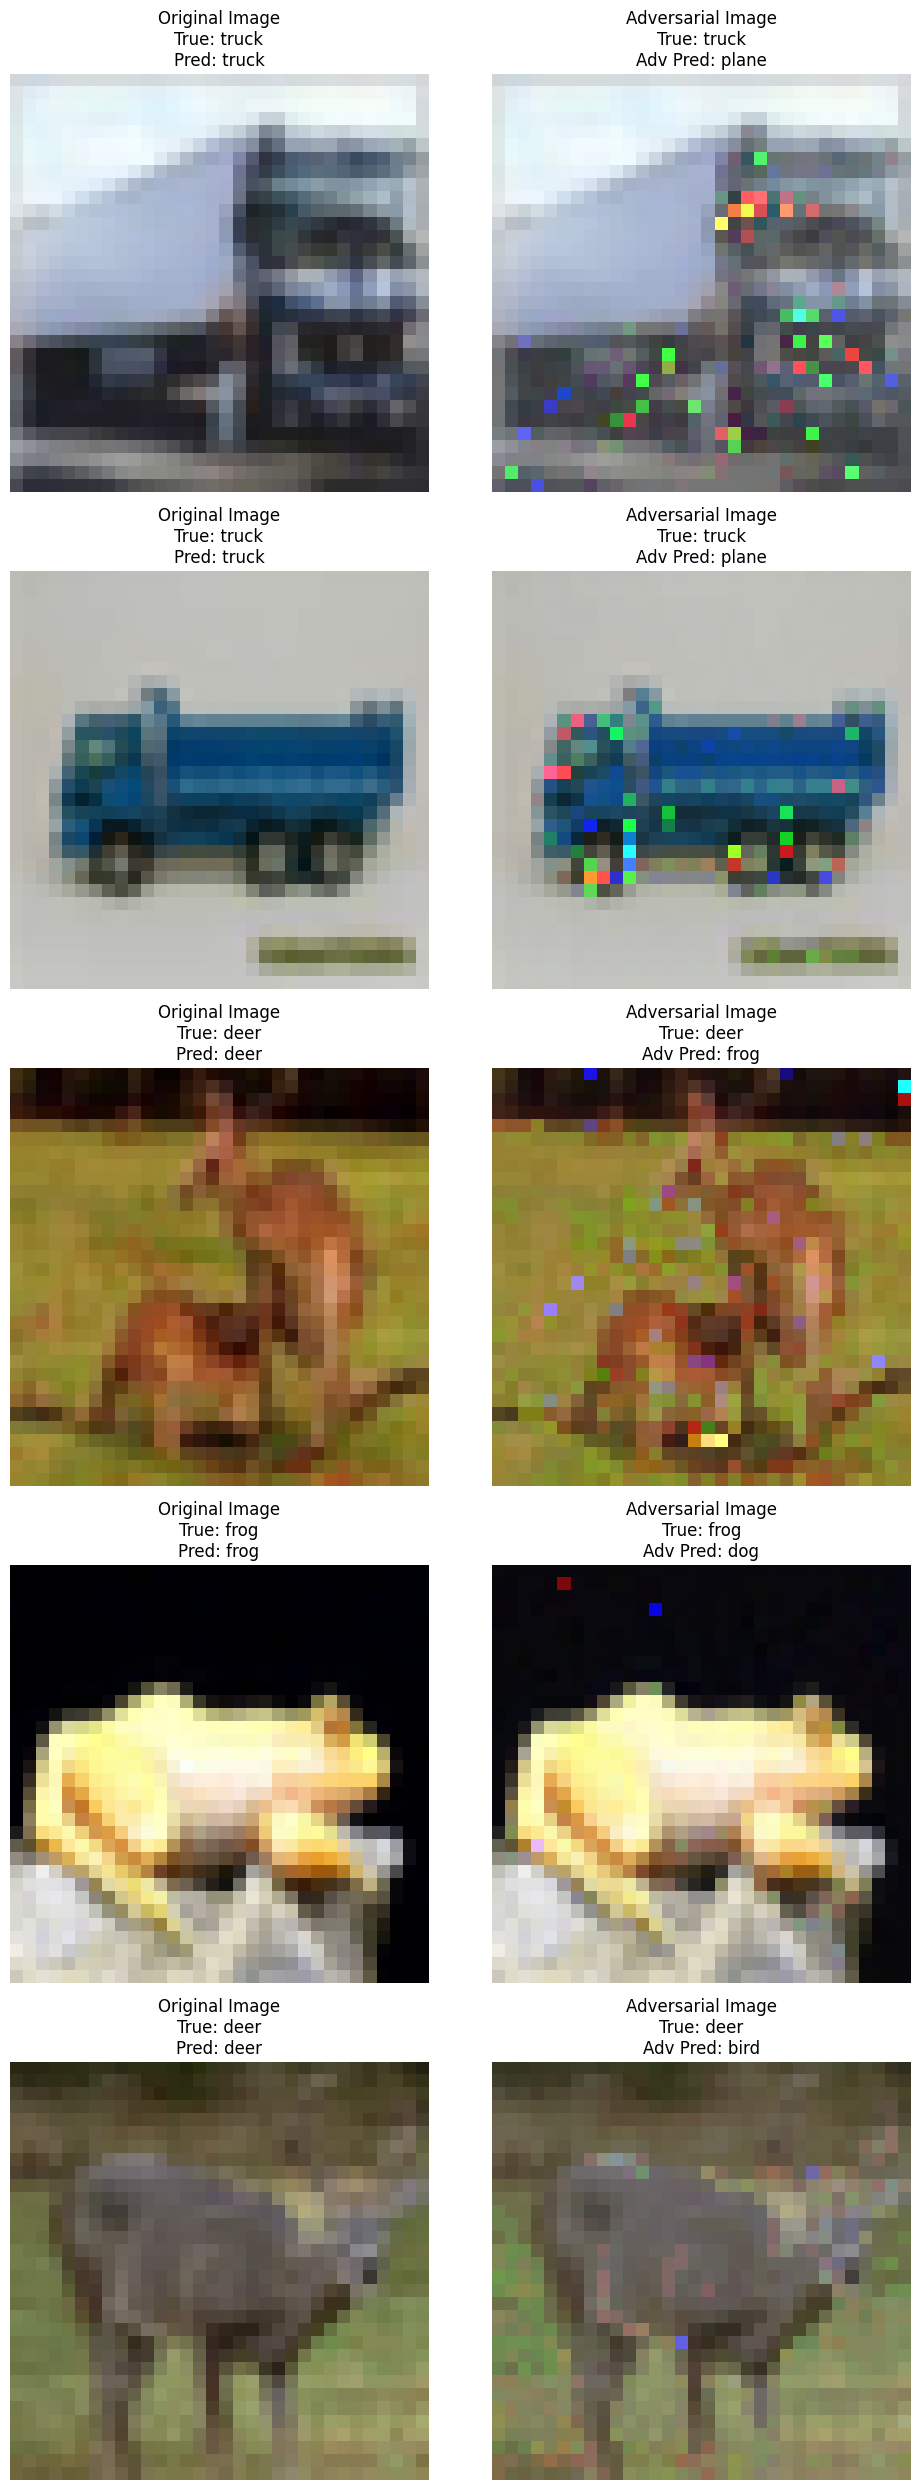

In [27]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the EADL1 Attack
attack_eadl1 = torchattacks.EADL1(model, kappa=0, lr=0.01, binary_search_steps=9, max_iterations=100, abort_early=True, initial_const=0.001, beta=0.001)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_eadl1(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


EADEN Attack

Success Rate: 0.6984


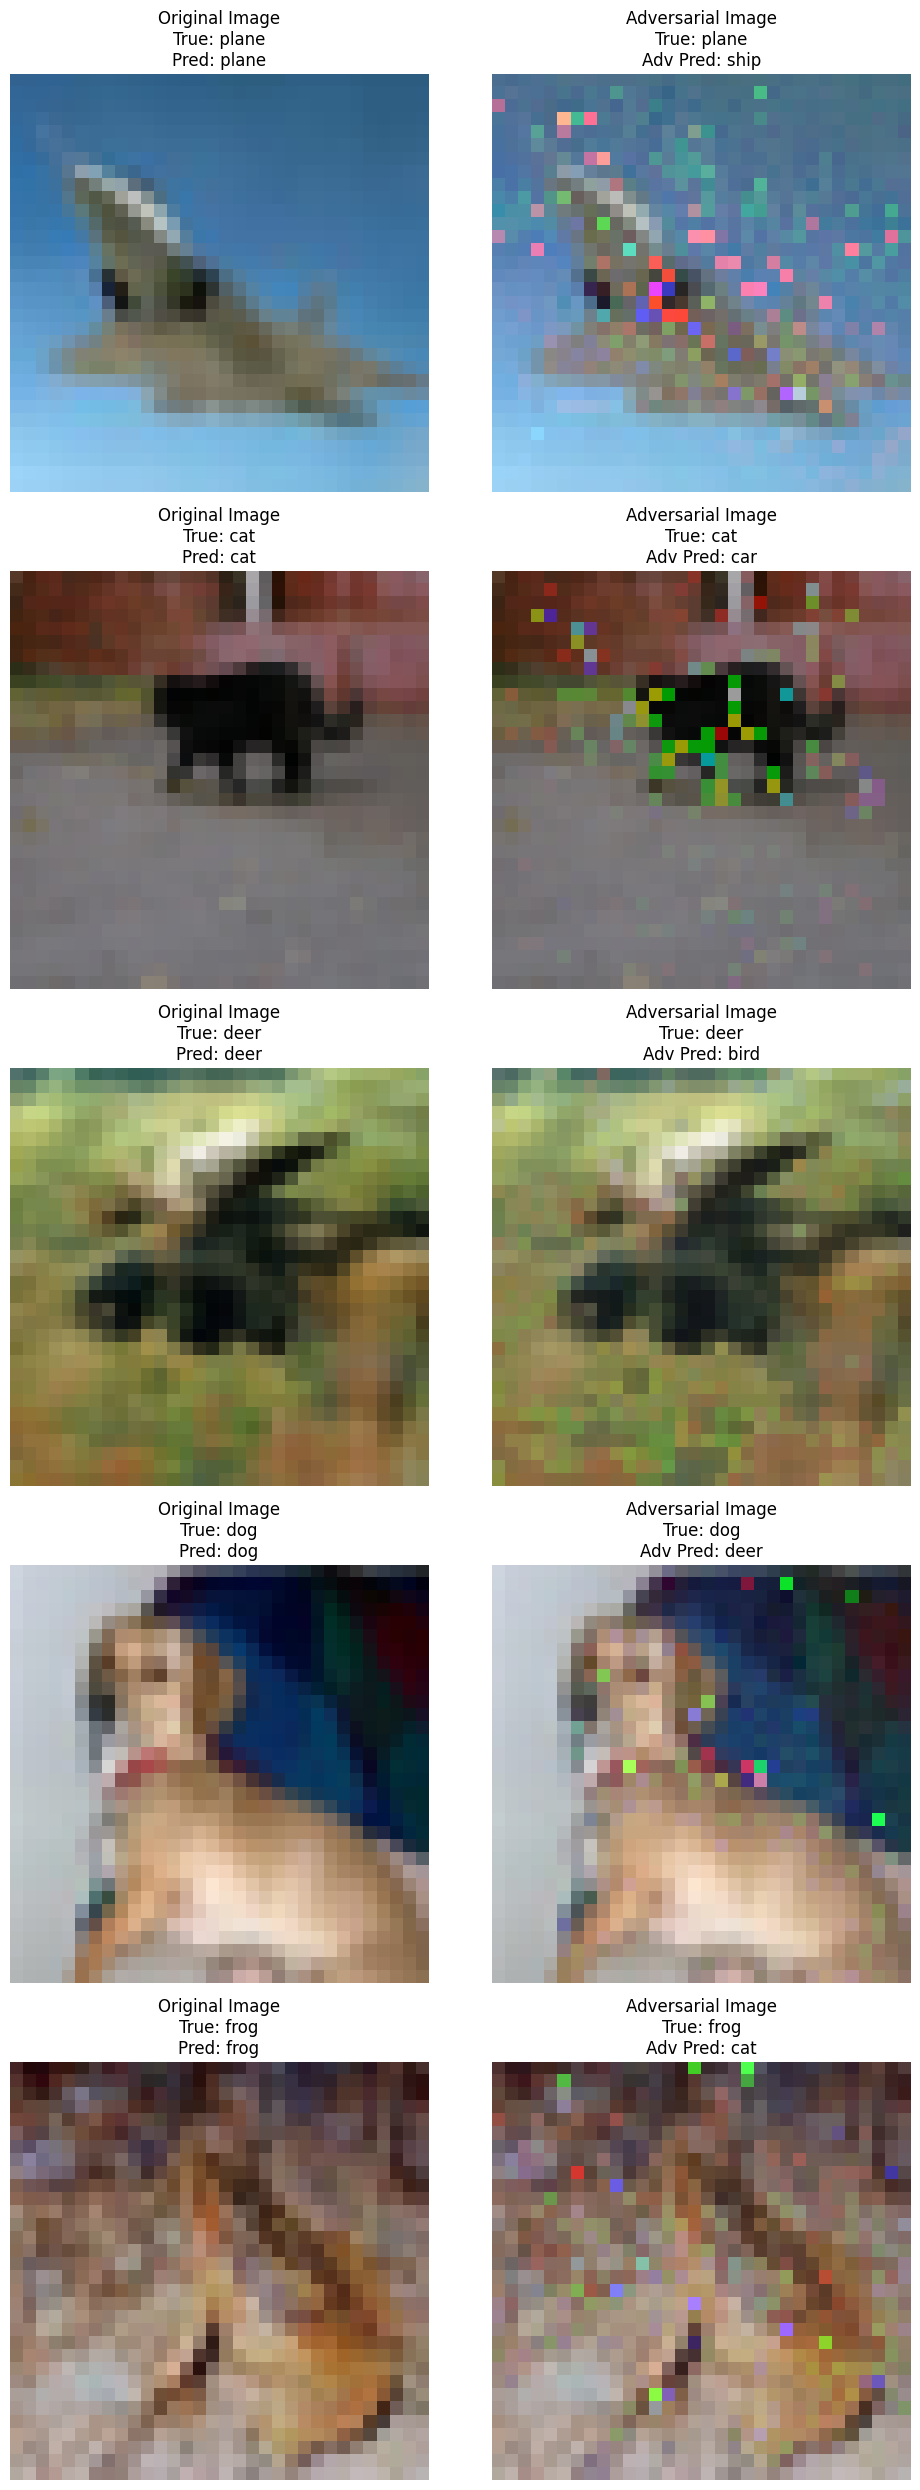

In [29]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the EADEN Attack
attack_eaden = torchattacks.EADEN(model, kappa=0, lr=0.01, binary_search_steps=9, max_iterations=100, abort_early=True, initial_const=0.001, beta=0.001)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_eaden(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


PIFGSM Attack

Success Rate: 0.7078


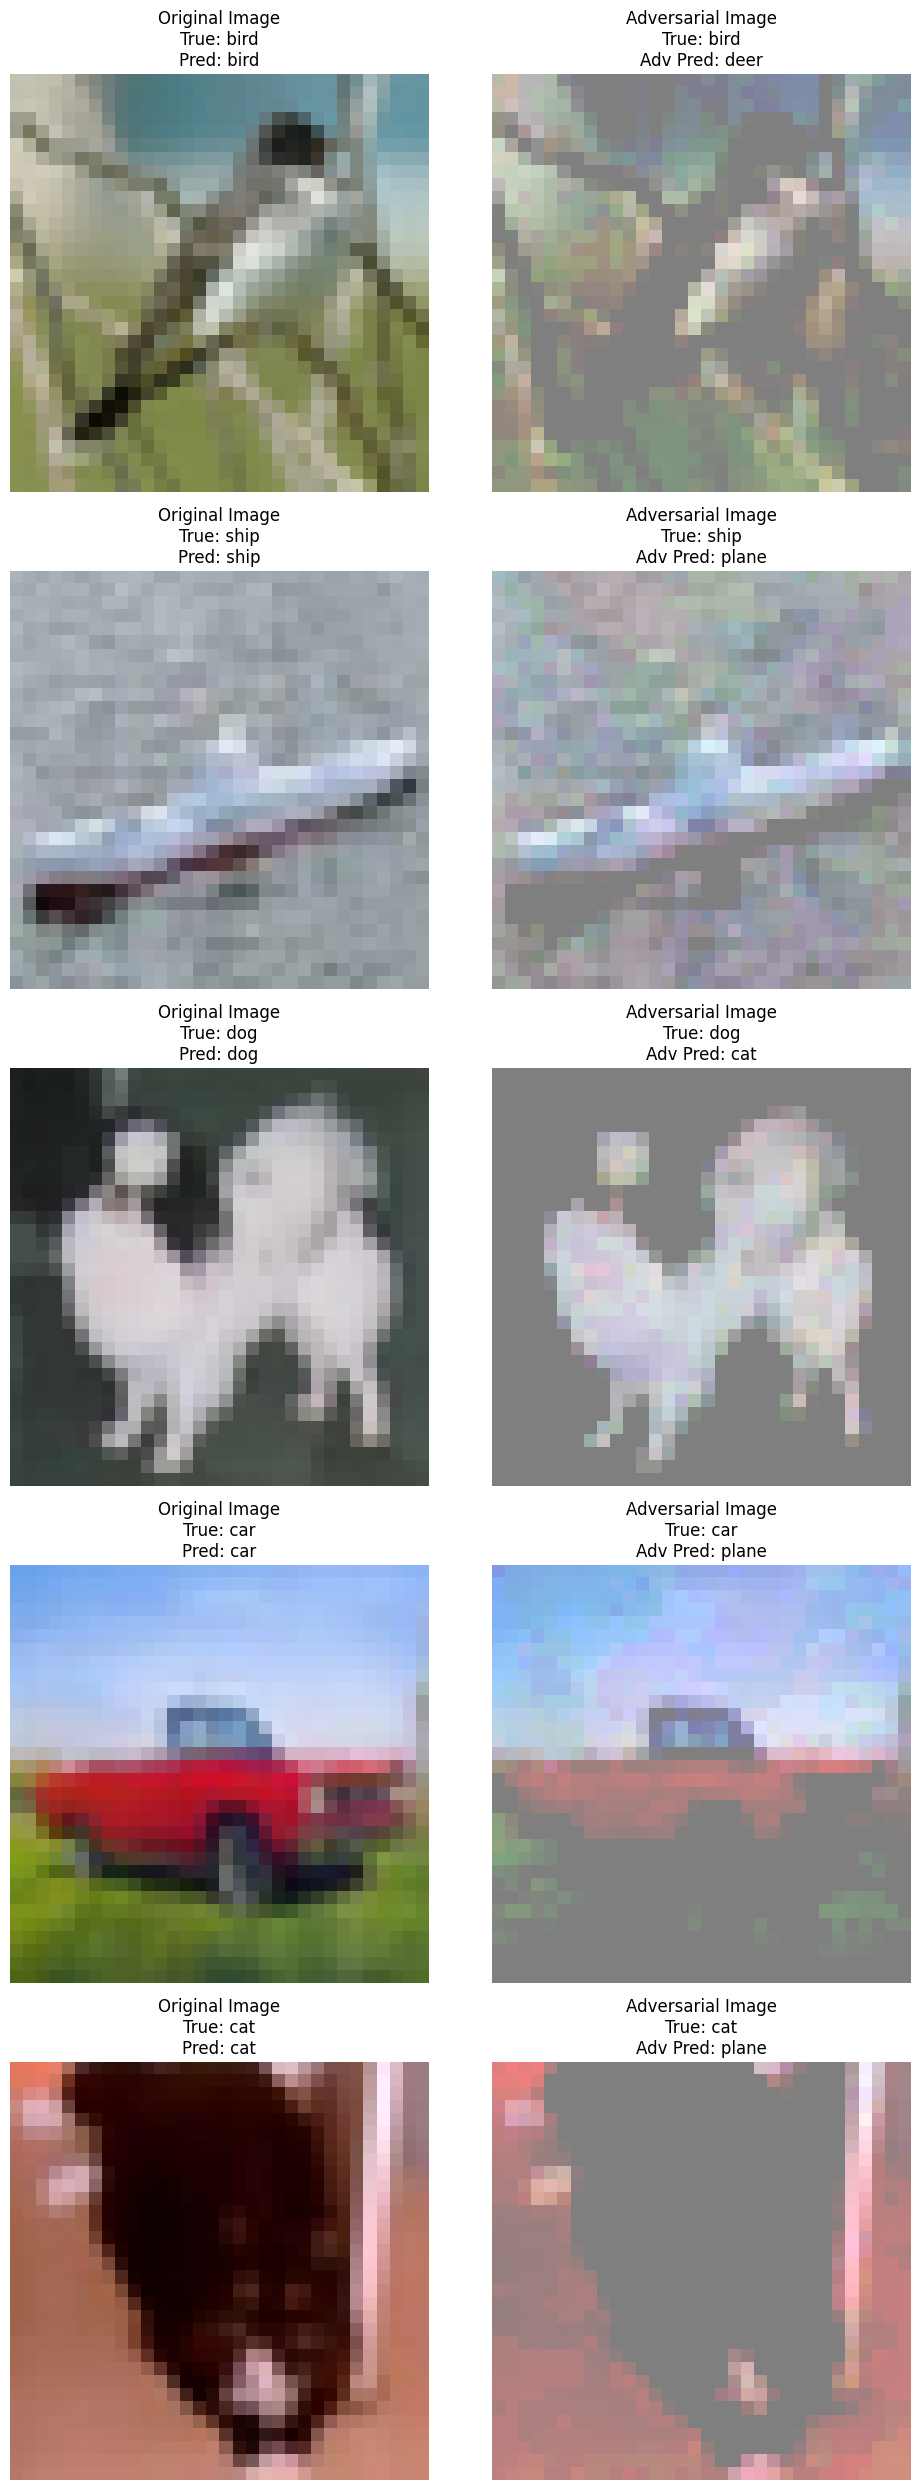

In [31]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the PIFGSM Attack
attack_pifgsm = torchattacks.PIFGSM(model, max_epsilon=16/255, num_iter_set=10, momentum=1.0, amplification=10.0, prob=0.7)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_pifgsm(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


PIFGSM++ Attack

Success Rate: 0.7031


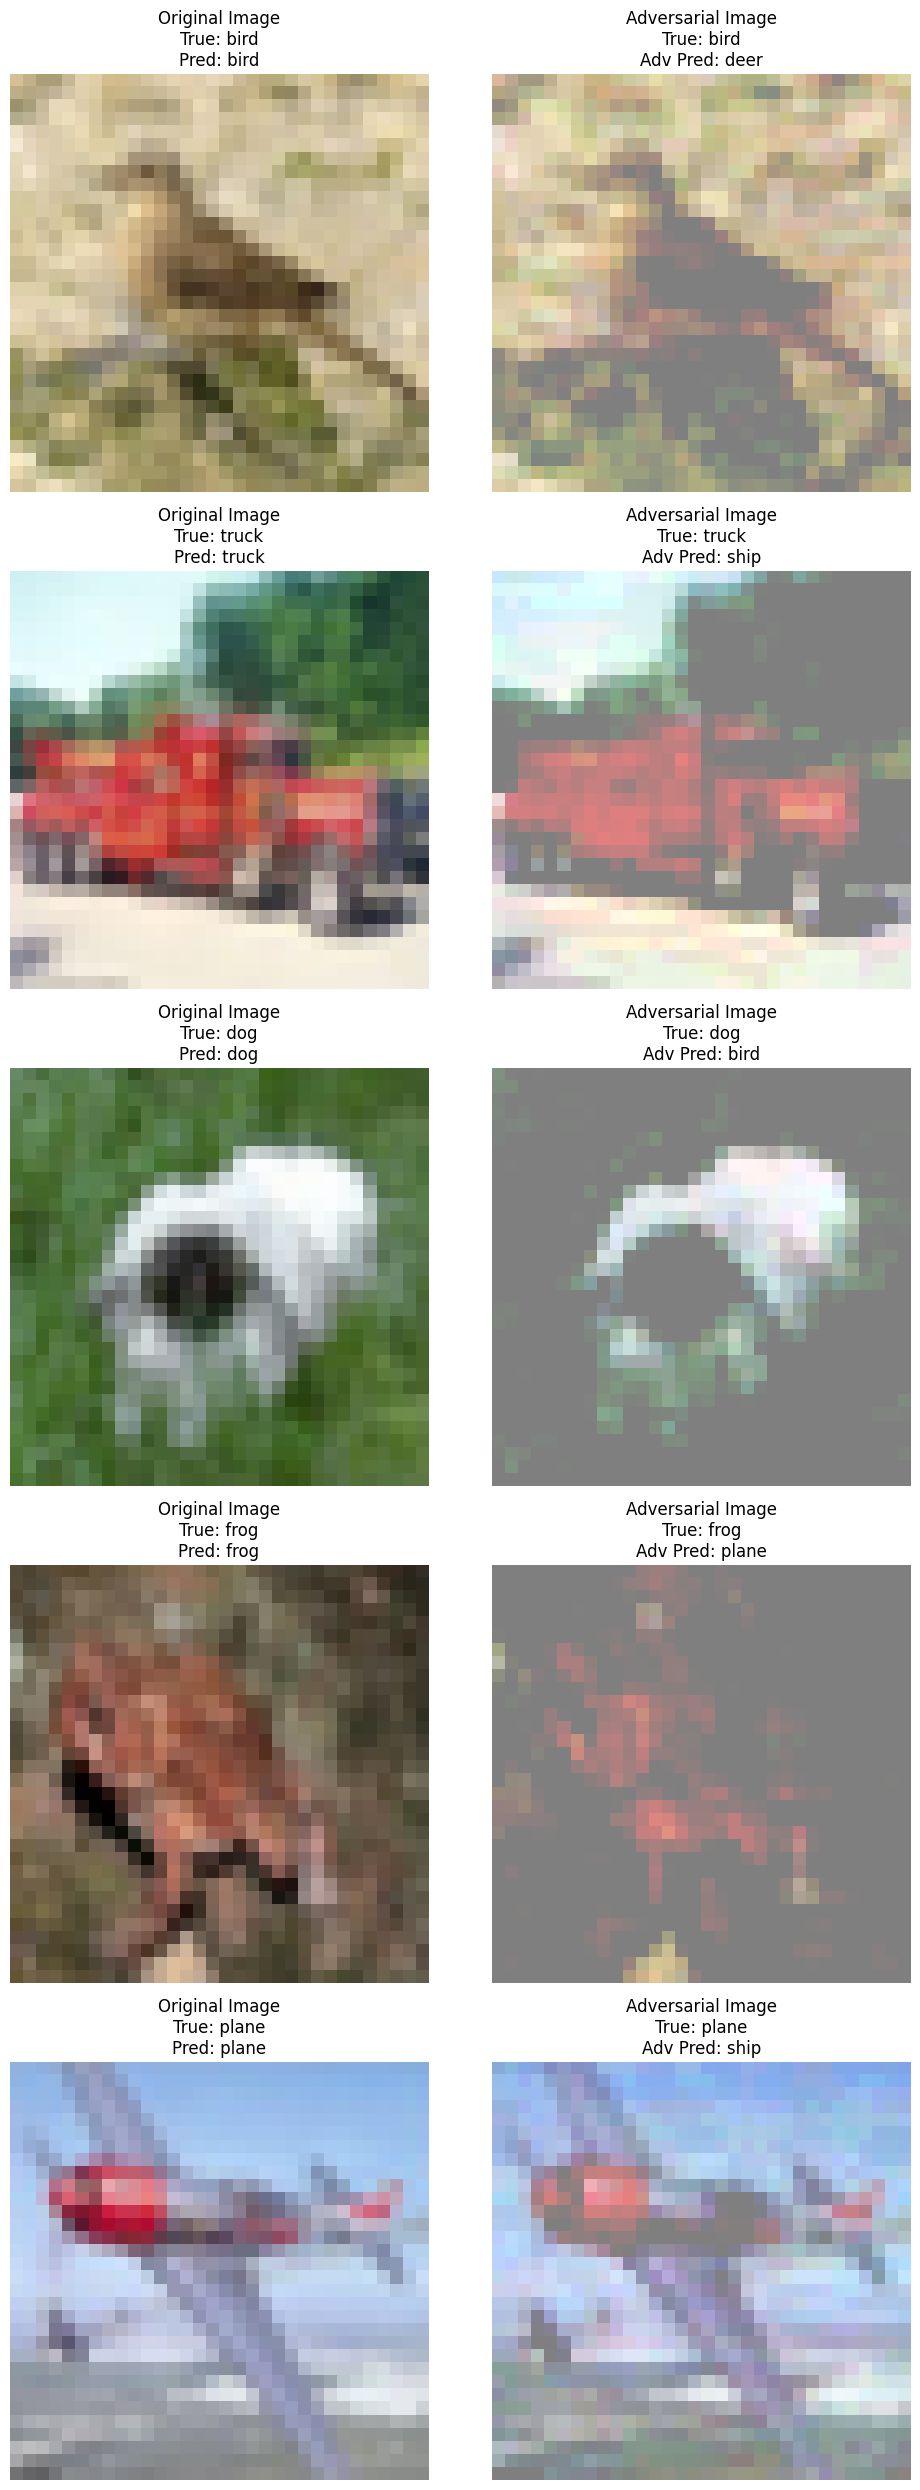

In [33]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the PIFGSMPP Attack
attack_pifgsmp = torchattacks.PIFGSMPP(model, max_epsilon=16/255, num_iter_set=10, momentum=1.0, amplification=10.0, prob=0.7, project_factor=0.8)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_pifgsmp(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()
